In [2]:
import os
import glob
import numpy as np
import pandas as pd
import clima_anom as ca
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from descartes import PolygonPatch

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from shapely.geometry import Polygon, Point
import rtree as rt

In [3]:
Ano = '2018'
Mes = '03'

In [4]:
lat_c = -22.8611
lon_c = -47.0563

resolution = 8/111

d = 180
r = (d)/111

In [5]:
lon_s = lon_c - 22.5*resolution
lon_e = lon_s + 45*resolution
print(f'lon start: {lon_s}')
print(f'lon end  : {lon_e}')
print()
lat_s = lat_c - 22.5*resolution
lat_e = lat_s + 45*resolution
print(f'lat start: {lat_s}')
print(f'lat end  : {lat_e}')

lon start: -48.67792162162162
lon end  : -45.43467837837838

lat start: -24.48272162162162
lat end  : -21.23947837837838


In [6]:
lon_ref = np.arange(lon_s,lon_e,resolution)
lat_ref = np.arange(lat_s,lat_e,resolution)
print(f'lon len: {len(lon_ref)}')
print(f'lat len: {len(lat_ref)}')

lon len: 45
lat len: 45


In [7]:
# Grilla Sao Paulo
lons = np.linspace(lon_s,lon_e,46)
lats = np.linspace(lat_s,lat_e,46)
print(f'lon grid len: {len(lons)}')
print(f'lat grid len: {len(lats)}')

lon grid len: 46
lat grid len: 46


In [8]:
grids = list()
for lat in range(lats.size-1):
    for lon in range(lons.size-1):
        lu = Point(lons[lon], lats[lat])
        ru = Point(lons[lon+1], lats[lat])
        rb = Point(lons[lon+1], lats[lat+1])
        lb = Point(lons[lon], lats[lat+1])
        poly = Polygon((lu, ru, rb, lb, lu))
        grids.append(poly)

grid = np.reshape(grids, (lats.size-1, lons.size-1))

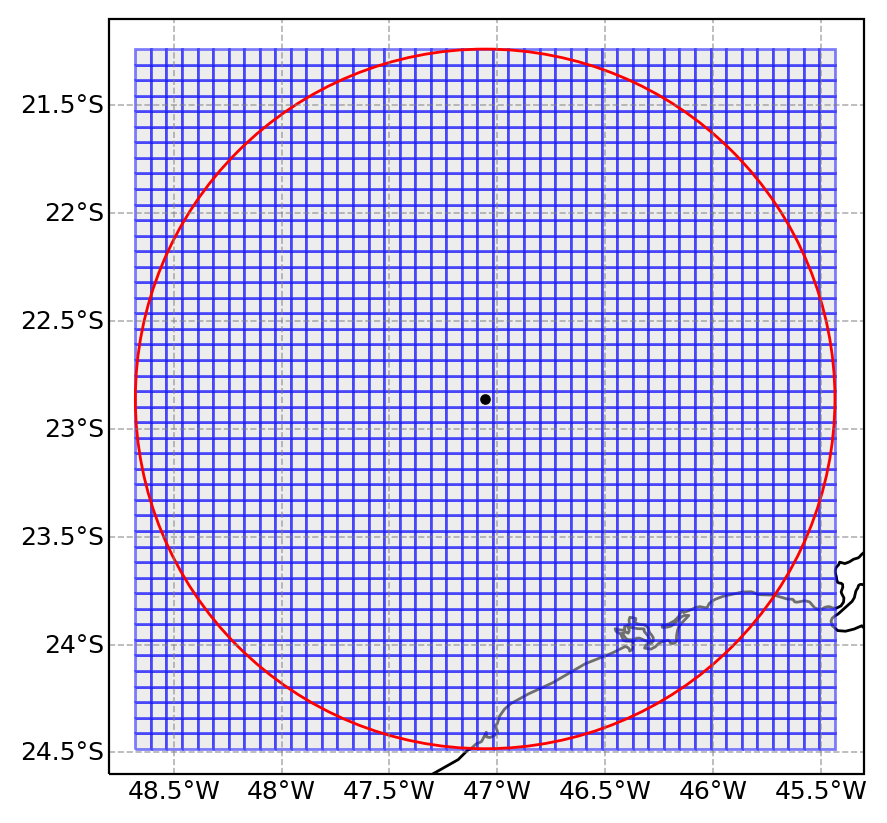

In [9]:
circle = plt.Circle((lon_c,lat_c), r, color='red',fill=False)

fig = plt.figure(figsize=(5,5),dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-48.8,-45.3,-24.6,-21.1])

for g in grids:
    patch = PolygonPatch(g, fc='#dcdcdc', ec='b', zorder=1, alpha=0.5)
    ax.add_patch(patch)

ax.scatter(lon_c,lat_c, s=8, color='black', zorder=3)
ax.add_artist(circle)

gl = ax.gridlines(crs = ccrs.PlateCarree(),draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 9, 'color': 'black'}
gl.ylabel_style = {'size': 9, 'color': 'black'}

In [78]:
list_dir = glob.glob('/mnt/Data/GLM/data/5min/*.csv')
lista = sorted(list_dir)
len(lista)

8928

In [79]:
num_dias = 31
tempos = num_dias*24*12
print('Numero de tiempos:',tempos)

Numero de tiempos: 8928


In [80]:
len(lat_ref),len(lon_ref)

(45, 45)

In [84]:
Densidad = np.zeros([tempos,len(lat_ref),len(lon_ref)])
count = 0

for i in range(tempos): 
            
    if os.path.exists(lista[i]):
        
        if i % 500 == 0 or i == tempos-1:
            print(i,'de',tempos)
            
        filename = lista[i].split('/')
        filename = filename[6]
        ano = filename.split('_')[1]
        mes = filename.split('_')[2]
        dia = filename.split('_')[3]
        hora = filename.split('_')[4]
        minu =filename.split('_')[5]

        data_in = pd.read_csv(lista[i])

        data = pd.DataFrame({'Lat':data_in['Lat'],'Lon':data_in['Lon']})

        tree = rt.index.Index()

        for i, row in data.iloc[:,:].iterrows():
            tree.insert(i, Point(row.Lon, row.Lat).bounds)

        mapping = list()

        for g in grids:
            matches = list(tree.intersection(g.bounds))
            mapping.append(len(matches))

        density = np.reshape(mapping, (lats.size-1, lons.size-1))

    else:
        print('   ',hora,minu,filename,'No Existe')
        density = np.zeros([len(lat_ref),len(lon_ref)])

    Densidad[count,:,:] = density
    count = count + 1

0 de 8928
500 de 8928
1000 de 8928
1500 de 8928
2000 de 8928
2500 de 8928
3000 de 8928
3500 de 8928
4000 de 8928
4500 de 8928
5000 de 8928
5500 de 8928
6000 de 8928
6500 de 8928
7000 de 8928
7500 de 8928
8000 de 8928
8500 de 8928
8927 de 8928


In [85]:
lon2d, lat2d = np.meshgrid(lon_ref,lat_ref)

In [86]:
flash_mean = np.mean(Densidad,axis=0)

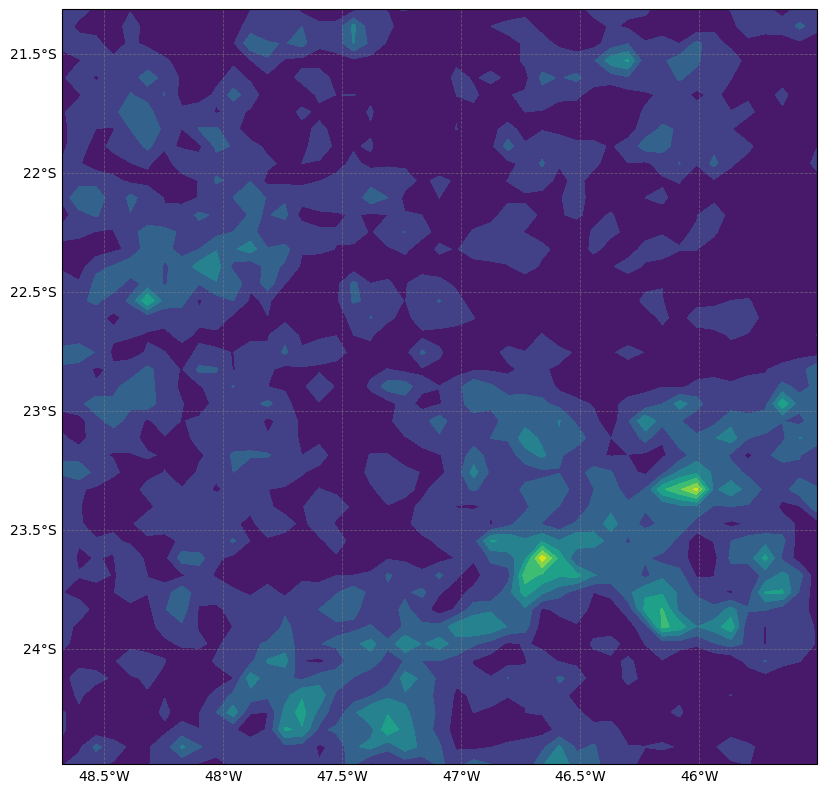

In [87]:
fig = plt.figure(figsize=(10,10),dpi=100)
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)
ax.coastlines()

ax.contourf(lon2d,lat2d,flash_mean)

gl = ax.gridlines(crs=proj,draw_labels=True,linewidth=0.6,color='gray',alpha=0.6,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False

In [89]:
np.shape(Densidad)
info = {'file': '/mnt/Data/GLM/data/GLM_2018_03_5min_8kmx8km.nc',
        'title': 'GLM data 14km x 14km', 
        'year_start':2019,'month_start':3,'day_start':1,'hour_start':0,'minute_start':0,
        'year_end':2019,'month_end':3,'day_end':31,'hour_end':23,'minute_end':55,
        'time_frequency': 'Minutely', 
        'time_interval': 5,
        'var_name': 'flash', 
        'var_units': 'flash/196km2'} 

In [90]:
ca.create_netcdf(info,Densidad,lat_ref,lon_ref)

Time Start: 2019-03-01 00:00:00
Time End: 2019-03-31 23:55:00
Time Frequency: Minutely
Time Lenght: 8928

File created in:  /mnt/Data/GLM/data/GLM_2018_03_010000_312355.nc
File title:  GLM data 14km x 14km
var title:  flash
var units:  flash/196km2
